<a href="https://colab.research.google.com/github/sunwookim1214/ImageCaptioning.pytorch/blob/master/AI501.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers tokenizers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00


In [3]:
!ls

all-data.csv  dataloader.py  drive  modeling.py  sample_data  trainer.py


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!nvidia-smi

Fri Jul  7 05:30:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
from modeling import *
from trainer import *
from dataloader import *

In [22]:
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

from transformers import DataCollatorWithPadding

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MAX_LEN = 512
BATCH_SIZE = 16

pre_trained_model_ckpt = 'bert-base-uncased'

class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len, include_raw_text=False):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.include_raw_text = include_raw_text

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            truncation = True,
            pad_to_max_length = True,
            return_tensors = 'pt',)

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }
        if self.include_raw_text:
            output['review_text'] = item
        return output


pre_trained_model_ckpt = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)

collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = 'longest' )

def create_data_loader(df, tokenizer, max_len = MAX_LEN, batch_size = BATCH_SIZE, include_raw_text = False):
    ds = ReviewDataset(
        reviews = df[1].to_list(),
        targets = df[0].to_list(),
        tokenizer=tokenizer,
        max_len=max_len,
        include_raw_text=include_raw_text
    )
    return DataLoader(ds, batch_size=batch_size, collate_fn=collator )


In [23]:
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


pre_trained_model_ckpt = 'yiyanghkust/finbert-tone'

class SentimentClassifier(nn.Module):
    """
    Sentiment classification model based on BERT.

    Args:
        n_classes (int): Number of classes for sentiment classification.

    """
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pre_trained_model_ckpt,return_dict=False)
        self.drop = nn.Dropout(p = 0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the sentiment classifier model.

        Args:
            input_ids (torch.Tensor): Input tensor of shape (batch_size, sequence_length).
            attention_mask (torch.Tensor): Attention mask tensor of shape (batch_size, sequence_length).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, n_classes).

        """
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask= attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [24]:
# -*- coding: utf-8 -*-

from modeling import *
from trainer import *
from dataloader import *

import sys

from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

# %matplotlib inline
# %config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("Paired"))

rcParams['figure.figsize'] = 12,8
RANDOM_SEED = 15
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


"""# Read Dataset"""

csv_file_path = 'all-data.csv'

df = pd.read_csv(csv_file_path, header=None, encoding = "ISO-8859-1")

# Make the customer stars starting from 0

tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)

df_train, df_test = train_test_split(df, test_size = 0.3, random_state = RANDOM_SEED)

df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

train_data_loader = create_data_loader(df_train, tokenizer)
val_data_loader = create_data_loader(df_val, tokenizer, include_raw_text=False)
test_data_loader = create_data_loader(df_test, tokenizer, include_raw_text=False)

#for d in val_data_loader:
    #print(d.keys())



# dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])

#Testing to see if the data loader works appropriately
data = next(iter(train_data_loader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

"""# Model Utility Class"""

model = SentimentClassifier(3)
model = model.to(device)

# An evaluation run of the model
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
F.softmax(model(input_ids,attention_mask), dim = 1)


"""# Training

## Training Loop Utility Functions
"""

#df.head()

EPOCHS = 10

optimizer = optim.AdamW(model.parameters(), lr= 1e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps=total_steps)

# For multi-class classification you would usually just use nn.CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss().to(device)

"""## Training Loop"""

# Commented out IPython magic to ensure Python compatibility.
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    print('-'*15)
    train_acc, train_loss = train_model(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc>best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask', 'targets'])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16])


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/ 10
---------------
Train loss 0.7398194643264672 accuracy 0.6780660152435303
Val loss 0.44722694741642993 accuracy 0.8253095149993896
Epoch 2/ 10
---------------
Train loss 0.3705292547227077 accuracy 0.8579009175300598
Val loss 0.38313208811956906 accuracy 0.8445667028427124
Epoch 3/ 10
---------------
Train loss 0.2322943766671672 accuracy 0.9183372855186462
Val loss 0.4428802986588815 accuracy 0.8500687479972839
Epoch 4/ 10
---------------
Train loss 0.1516732040283112 accuracy 0.9522405862808228
Val loss 0.517084682866445 accuracy 0.8514443039894104
Epoch 5/ 10
---------------
Train loss 0.11473194493819906 accuracy 0.9643278121948242
Val loss 0.5693354088934544 accuracy 0.8569463491439819
Epoch 6/ 10
---------------
Train loss 0.07703345736987309 accuracy 0.9752358198165894
Val loss 0.6268784146877411 accuracy 0.8596974015235901
Epoch 7/ 10
---------------
Train loss 0.05065460459116126 accuracy 0.9867334961891174
Val loss 0.7054409280712919 accuracy 0.8541952967643738
Ep

In [25]:
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    """
    Trains the given model using the provided data loader and optimizer.

    Args:
        model (torch.nn.Module): Model to train.
        data_loader (DataLoader): DataLoader providing the training data.
        loss_fn: Loss function to optimize.
        optimizer: Optimizer for updating the model's parameters.
        device: Device to use for training.
        scheduler: Learning rate scheduler.
        n_examples (int): Total number of training examples.

    Returns:
        float: Accuracy of the model on the training data.
        float: Average training loss.

    """
    model=model.train()
    losses = []
    correct_predictions = 0

    """  iterate over the batches provided by the data loader. Within each iteration, the batch tensors are moved to the appropriate device. The model performs a forward pass on the input tensors, and the predicted labels are obtained by taking the maximum value along the appropriate dimension. """
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets).cpu()

        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions/n_examples, np.mean(losses)
''' clip_grad_norm - We tackle the problem of exploding and vanishing gradients By gradient clipping '''


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            _,preds = torch.max(outputs, dim = 1)

            loss = loss_fn(outputs, targets.detach())
            correct_predictions += torch.sum(preds == targets).cpu()
            losses.append(loss.item())
    return correct_predictions/n_examples, np.mean(losses)

# Model Evaluation on test_data_loader
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            #texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim =1)
            #review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, prediction_probs, real_values

              precision    recall  f1-score   support

     neutral       0.89      0.90      0.90       423
    positive       0.84      0.80      0.82       213
    negative       0.84      0.88      0.86        91

    accuracy                           0.87       727
   macro avg       0.86      0.86      0.86       727
weighted avg       0.87      0.87      0.87       727



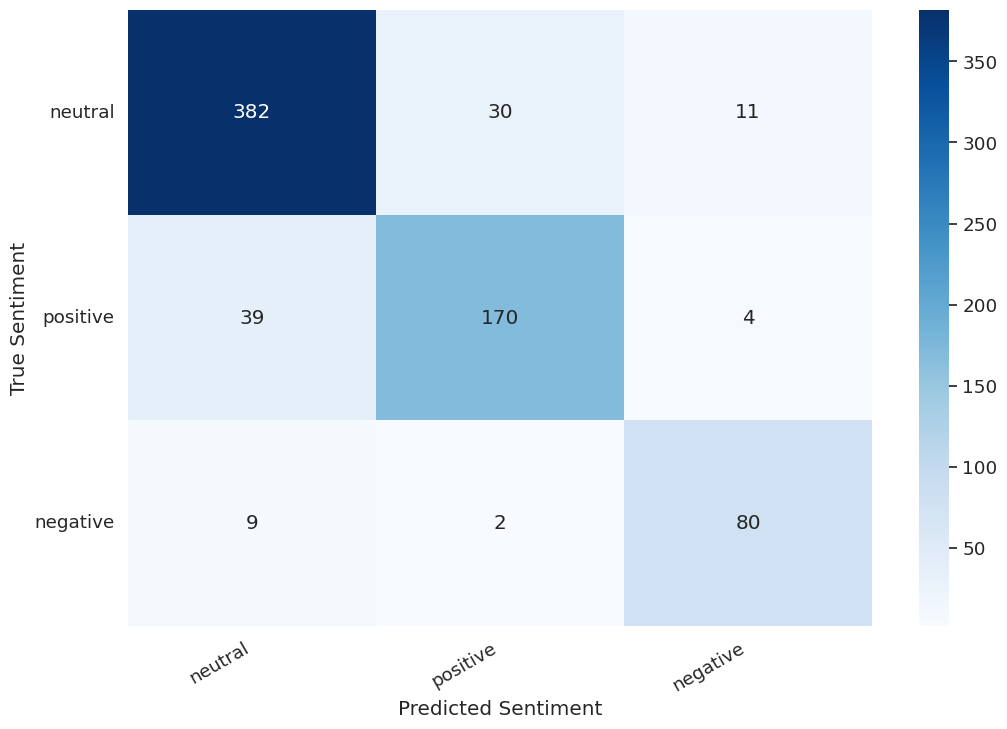

In [26]:
class_names = ['neutral', 'positive', 'negative']
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

In [32]:
review_text = "singapore stock benchmark heads for lowest close in eight months"
encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: singapore stock benchmark heads for lowest close in eight months
Sentiment  : negative


In [28]:
review_text = "Markets wrap with prospectors bullish"
encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Markets wrap with prospectors bullish
Sentiment  : neutral
